<a href="https://colab.research.google.com/github/chang-heekim/Oxford-Pet-Dataset/blob/main/Oxford_Pet_Dataset_Basic_Classification_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Necessary Library

In [ ]:
import numpy as np
import pandas as pd
import os 
import math
import random
import cv2

from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, ReLU
from PIL import Image

# Preprocessing Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/oxford_pet/annotations/list.txt', skiprows=6, delimiter=' ', header=None)
df.columns = ['file_name', 'id', 'species', 'breed']
df.head()

,file_name,id,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [ ]:
image_dir = '/content/drive/MyDrive/dataset/oxford_pet/images/'
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
n_images = len(image_files)
print(n_images)

7378


In [ ]:
images = []
labels = []
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image_mode = image.mode
    image = tf.image.resize(np.array(image), (224, 224))
    if image_mode != 'RGB':
        image = np.asarray(image)
        os.remove(image_path)
    else:
        images.append(image)

    if image_file.isupper():
        labels.append(0)
    else:
        labels.append(1)

images = np.array(images) / 255.
labels = np.array(labels) 

print(len(images), len(labels))

7378 7378


In [ ]:
train_size = int(len(images) * 0.9)
val_size = len(images) - train_size

train_batch_size = 64
val_batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices((images, labels))

train_dataset = dataset.take(train_size)
val_dataset = dataset.take(val_size)

train_loader = train_dataset.batch(train_batch_size, drop_remainder=True).shuffle(1024)
val_loader = val_dataset.batch(val_batch_size, drop_remainder=True)

In [ ]:
for sample_batch in train_dataset:
    print(sample_batch)
    print(sample_batch[0].shape)
    break

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6618052 , 0.68254596, 0.82944614],
        [0.6899241 , 0.7325746 , 0.85930467],
        [0.67756605, 0.7262669 , 0.86180323],
        ...,
        [0.87933576, 0.8566645 , 0.7216017 ],
        [0.87708735, 0.9450813 , 0.8907427 ],
        [0.9032675 , 0.9082475 , 0.8245434 ]],

       [[0.71145517, 0.74129236, 0.8776435 ],
        [0.6849887 , 0.7432952 , 0.8962867 ],
        [0.7113164 , 0.7722829 , 0.89169645],
        ...,
        [0.642259  , 0.6137846 , 0.4979358 ],
        [0.6399421 , 0.70226294, 0.6117988 ],
        [0.6087765 , 0.6806364 , 0.5759515 ]],

       [[0.6956098 , 0.7490592 , 0.8919975 ],
        [0.68280303, 0.73721284, 0.8880725 ],
        [0.6991188 , 0.7566465 , 0.88475996],
        ...,
        [0.698756  , 0.72046494, 0.59126294],
        [0.6329221 , 0.72034323, 0.5756296 ],
        [0.5388364 , 0.64991885, 0.5054893 ]],

       ...,

       [[0.1025739 , 0.15098642, 0.19235626],
        [0.0

In [ ]:
classes = {
    0: 'Cat',
    1: 'Dog',
}

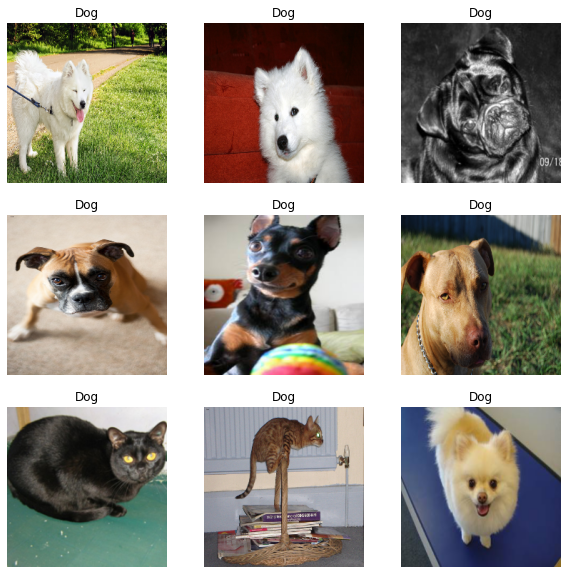

In [ ]:
sample = next(iter(train_loader))
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample[0][i])
    plt.axis('off')
    plt.title(classes[sample[1][i].numpy()])
plt.show()

# Define ResNet

In [ ]:
class BasicBlock(tf.keras.Model):
    def __init__(self, filter_in, filter_out, stride):
        super().__init__()

        self.conv1 = Conv2D(filter_out, kernel_size=3, strides=stride, padding='same')
        self.bn1 = BatchNormalization()

        self.conv2 = Conv2D(filter_out, kernel_size=3, padding='same')
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()

        if stride == 2:
            self.identity = Conv2D(filter_out, kernel_size=1, strides=stride, padding='same')
        else:
            self.identity = lambda x: x

    def call(self, x, training=False):
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = tf.nn.relu(out)
        out = self.conv2(out)
        out = self.bn2(out, training=training)
        out = tf.nn.relu(out)
        out += self.bn3(self.identity(x), training=training)
        return out

class BottleNeck(tf.keras.Model):
    def __init__(self, filter_in, filter_out, stride, expansion=4):
        super().__init__()

        self.conv1 = Conv2D(filter_out, kernel_size=1, strides=stride, padding='same')
        self.bn1 = BatchNormalization()

        self.conv2 = Conv2D(filter_out, kernel_size=3, padding='same')
        self.bn2 = BatchNormalization()

        self.conv3 = Conv2D(filter_out * expansion, kernel_size=1, padding='same')
        self.bn3 = BatchNormalization()
        self.bn4 = BatchNormalization()

        if stride == 2 or filter_in != filter_out * expansion:
            self.identity = Conv2D(filter_out * expansion, 1, strides=stride, padding='same')
        else:
            self.identity = lambda x: x
    
    def call(self, x, training=False):
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = tf.nn.relu(out)
        out = self.conv2(out)
        out = self.bn2(out, training=training)
        out = tf.nn.relu(out)
        out = self.conv3(out)
        out = self.bn3(out, training=training)
        out = tf.nn.relu(out)
        out += self.bn4(self.identity(x), training=training)

        return out


class ResNet(tf.keras.Model):
    def __init__(self, block, num_blocks):
        super().__init__()
        self.filter_in = 64

        self.conv1 = Conv2D(64, kernel_size=7, strides=2, padding='same')
        self.bn1= BatchNormalization()
        self.maxpool1 = MaxPool2D(3, 2)

        self.layer1 = self.residual_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.residual_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.residual_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.residual_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = tf.keras.layers.AveragePooling2D((1,1))
        self.flatten = tf.keras.layers.Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def residual_layer(self, block, filter_out, num_block, stride):
        strides = [stride] + [1] * (num_block - 1)
        layers = tf.keras.Sequential()
        for stride in strides:
            layers.add(block(self.filter_in, filter_out, stride))
            self.filter_in = filter_out * 4
        return layers

    def call(self, x, training=False):
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.maxpool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)

        out = self.flatten(out)
        out = self.dense(out)
        return out

In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

# Define Model & Loss & Optimizer & Early_Stop_Callback

In [ ]:
lr = 1e-2
epochs = 50

model = ResNet18()
model.build((None, 224, 224, 3))
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=['accuracy']
)

save_path = '/content/runs/checkpoints'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=3, verbose=True)

Model: "res_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_50 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 sequential_8 (Sequential)   (None, 55, 55, 64)        149248    
                                                                 
 sequential_9 (Sequential)   (None, 28, 28, 128)       528000    
                                                                 
 sequential_10 (Sequential)  (None, 14, 14, 256)       21

# Training

In [ ]:
hist = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=epochs,
    callbacks=[checkpoint, early_stop_callback]
)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9964
Epoch 00001: val_loss improved from inf to 0.00000, saving model to /content/runs/checkpoints
INFO:tensorflow:Assets written to: /content/runs/checkpoints/assets
103/103 [==============================] - 34s 297ms/step - loss: 0.0073 - accuracy: 0.9964 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 00002: val_loss did not improve from 0.00000
103/103 [==============================] - 18s 163ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 00003: val_loss did not improve from 0.00000
103/103 [==============================] - 18s 164ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
103/103

# Visualization Loss & Accuracy

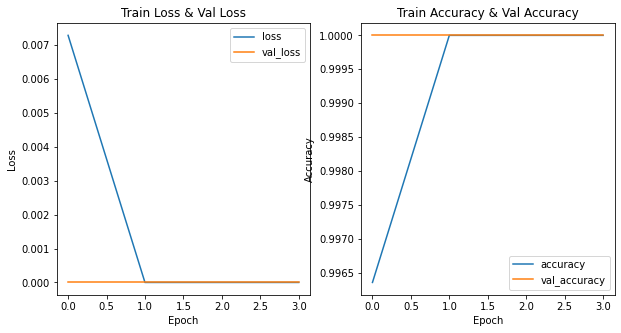

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Train Loss & Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(122)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='best')
plt.title('Train Accuracy & Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test Model

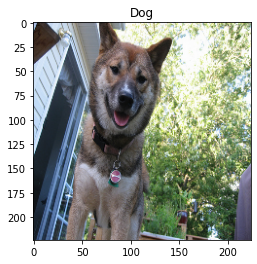

Pred Label:  Dog


In [ ]:
img , label = next(iter(val_loader))
img, label = img[0:1], label[0]

plt.imshow(img[0])
plt.title(classes[label.numpy()])
plt.show()

pred = model.predict(img)

print('Pred Label: ', classes[pred[0][0]])